In [171]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
project_root = Path.cwd().parent.parent  # Assuming notebook is in experiments/notebooks/
sys.path.insert(0, str(project_root))
print(sys.path)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from experiments.analysis_utils.data_processing import read_directory
from experiments.analysis_utils.visualization import plot_reaction_speed_distribution, plot_token_distribution

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/PycharmProjects/dg-research-revision', '/home/rotsker/miniconda3/envs/radCAD/lib/python312.zip', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/lib-dynload', '', '/home/rotsker/miniconda3/envs/radCAD/lib/python3.12/site-packages']


In [172]:
from model.utils.seed import initialize_seed
from model.utils.reactions import determine_reaction_time_vector
from model.types.reaction_time import ReactionTime, ModeledReactions

def get_actor_category(**kwargs):
    # Get the length of the first boolean numpy array
    first_key = next(iter(kwargs))
    length = len(kwargs[first_key])
    
    # Create an array of strings initialized with a default value
    actor_category = np.array(['Normal'] * length)
    
    # Apply masks to set corresponding names
    for mask_name, mask in kwargs.items():
        actor_category[mask] = mask_name
    
    return actor_category

def get_abstaining_mask(wallet_df):
    actor_typestr = np.array(wallet_df.type)
    abstaining_mask = np.isin(actor_typestr, ['Contract', 'CEX', 'Custody'])
    return abstaining_mask

def get_institutional_mask(wallet_df, institutional_threshold: float = 3000):
    institutional_mask = wallet_df.total >= institutional_threshold
    return institutional_mask

def get_reaction_time_distribution(wallet_df, 
                                   reactions: ModeledReactions = ModeledReactions.Normal,
                                   institutional_threshold: float = 3000):
    reaction_time_vector = determine_reaction_time_vector(len(wallet_df), reactions)

    institutional_mask = get_institutional_mask(wallet_df, institutional_threshold)
    reaction_time_vector[institutional_mask] = ReactionTime.Slow.value

    abstaining_mask = get_abstaining_mask(wallet_df)
    reaction_time_vector[abstaining_mask] = ReactionTime.NoReaction.value

    actor_category = get_actor_category(
        Institutional=institutional_mask,
        Abstaining=abstaining_mask,
    )

    return reaction_time_vector, actor_category

# Distributions

In [4]:
wallet_tuples = [('original', 'stETH token distribution  - stETH+wstETH holders'),
                 ('centralized', 'centralized_wallet_distribution'),
                 ('decentralized', 'decentralized_wallet_distribution')]
wallet_dfs = []
for name, filename in wallet_tuples:
    wallet_df = pd.read_csv(Path('../../data').joinpath(filename + '.csv'))
    wallet_df['distribution'] = name
    wallet_df['total_token_share'] = wallet_df['total'] / wallet_df['total'].sum()
    wallet_dfs.append(wallet_df)
wallet_df_combined = pd.concat(wallet_dfs, ignore_index=True)


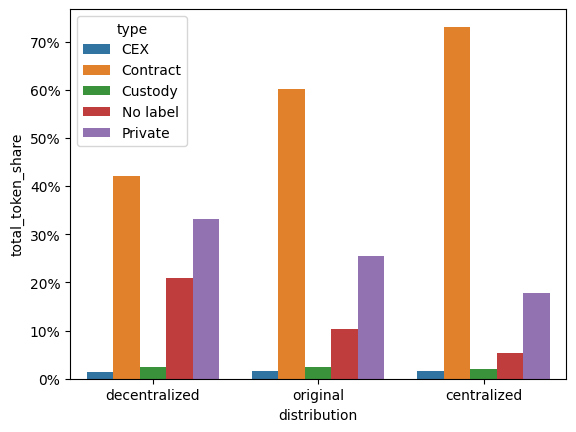

In [17]:
from matplotlib.ticker import PercentFormatter
ax = sns.barplot(
    data=wallet_df_combined.groupby(['distribution', 'type']).total_token_share.sum().reset_index(),
    x='distribution',
    y='total_token_share',
    hue='type',
    order=['decentralized', 'original', 'centralized'])
ax.yaxis.set_major_formatter(PercentFormatter(1))

In [41]:

for distribution in ['decentralized', 'original', 'centralized']:
    mask = wallet_df_combined.distribution == distribution
    initialize_seed(100)
    reaction_time_vector, _ = get_reaction_time_distribution(wallet_df_combined[mask], reactions=ModeledReactions.Normal)
    wallet_df_combined.loc[mask, 'reaction_time_vector'] = reaction_time_vector

wallet_df_combined['reaction_time'] = wallet_df_combined['reaction_time_vector'].map(lambda x: ReactionTime(x).name)

Text(0.5, 1.0, 'Average reaction time')

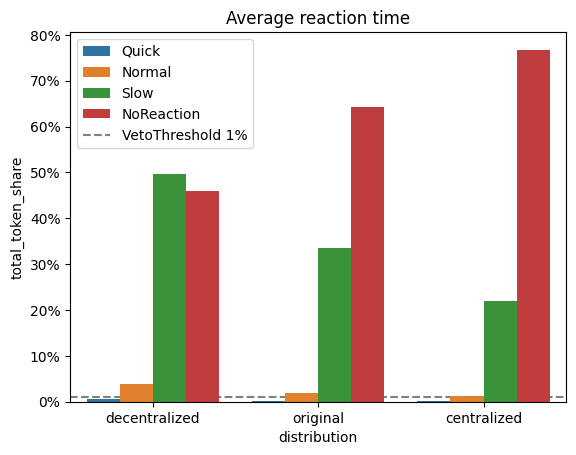

In [42]:
ax =sns.barplot(
    data=wallet_df_combined.groupby(['distribution', 'reaction_time']).total_token_share.sum().reset_index(),
    x='distribution',
    y='total_token_share',
    hue='reaction_time',
    order=['decentralized', 'original', 'centralized'],
    hue_order=['Quick', 'Normal', 'Slow', 'NoReaction'])
ax.yaxis.set_major_formatter(PercentFormatter(1))
xlim = ax.get_xlim()
ax.plot(xlim, [0.01, 0.01], color='gray', linestyle='--', label='VetoThreshold 1%', zorder=0)
ax.set_xlim(xlim)
ax.legend()
ax.set_title('Average reaction time')


Text(0.5, 1.0, 'Average reaction time')

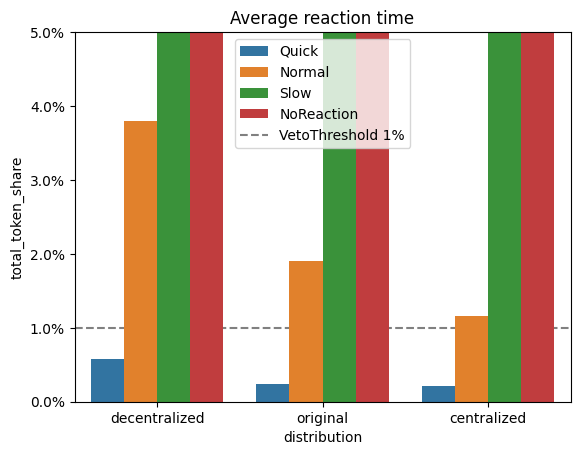

In [43]:
ax = sns.barplot(
    data=wallet_df_combined.groupby(['distribution', 'reaction_time']).total_token_share.sum().reset_index(),
    x='distribution',
    y='total_token_share',
    hue='reaction_time',
    order=['decentralized', 'original', 'centralized'],
    hue_order=['Quick', 'Normal', 'Slow', 'NoReaction'])
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.set_ylim(0, 0.05)
ax.plot(xlim, [0.01, 0.01], color='gray', linestyle='--', label='VetoThreshold 1%', zorder=0)
ax.set_xlim(xlim)
ax.legend()
ax.set_title('Average reaction time')

Text(0.5, 1.0, 'Average amount of wallets for each reaction time')

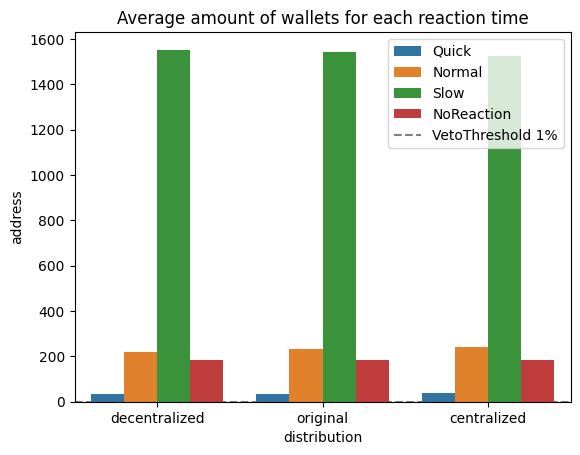

In [44]:
ax = sns.barplot(
    data=wallet_df_combined.groupby(['distribution', 'reaction_time']).address.count().reset_index(),
    x='distribution',
    y='address',
    hue='reaction_time',
    order=['decentralized', 'original', 'centralized'],
    hue_order=['Quick', 'Normal', 'Slow', 'NoReaction'])
ax.set_xlim(xlim)
ax.legend()
ax.set_title('Average amount of wallets for each reaction time')

# Cluster A

In [8]:
path_to_runs = Path("../../results/simulations/clusterA_future_proof/")
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve(), pass_directory_name=True)
for df in [proposal_df_full, start_data_df_full, timestep_data_df_full]:
    df["wallet_distribution"] = df["directory_name"].str.split("_").str[0]
    df["ModeledReactions"] = df["directory_name"].str.split("_").str[1]


In [9]:
from experiments.analysis_utils.metrics import analyze_veto_timing_by_seals
veto_stats = analyze_veto_timing_by_seals(timestep_data_df_full, start_data_df_full, additional_columns=('wallet_distribution', 'ModeledReactions'))
print("Veto statistics for different wallet distributions and ModeledReactions:")
display(veto_stats)

Veto statistics for different wallet distributions and ModeledReactions:


veto_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions              
0.01                         0.1                           centralized         accelerated           100.0   
                                                                               normal                 91.0   
                                                                               slowed                  0.0   
                                                           decentralized       accelerated           100.0   
                                                                               normal                100.0   
                                                                               slowed                100.0   
                                                           original            accelerated           100.0   
                                                                               normal                100.0   
                                                                               slowed                 98.0   

                                                                                                 mean_time_to_veto  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions                      
0.01                         0.1                           centralized         accelerated               26.970000   
                                                                               normal                    33.087912   
                                                                               slowed                          NaN   
                                                           decentralized       accelerated                7.480000   
                                                                               normal                    21.180000   
                                                                               slowed                    23.700000   
                                                           original            accelerated               22.320000   
                                                                               normal                    26.000000   
                                                                               slowed                    31.561224   

                                                                                                 median_time_to_veto  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions                        
0.01                         0.1                           centralized         accelerated                      27.0   
                                                                               normal                           33.0   
                                                                               slowed                            NaN   
                                                           decentralized       accelerated                       7.0   
                                                                               normal                           21.0   
                                                                               slowed                           24.0   
                                                           original            accelerated                      22.0   
                                                                               normal                           26.0   
                                                                               slowed                           31.0   

                                                                                                 hours_mean_time_to_veto_hours  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions                                  
0.01  

In [12]:
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on='run_id', how='left')
threshold_times = timestep_data_df_full_with_params.groupby('run_id').apply(lambda x: x[x['actors_total_locked_relative'] >= x['second_seal_rage_quit_support']]['timestep'].min()).reset_index(name='threshold_timestep')
threshold_times['threshold_hours'] = threshold_times['threshold_timestep'] * 3
threshold_times = threshold_times.merge(start_data_df_full, on='run_id', how='left')

print("RageQuit threshold times for different wallet distributions and ModeledReactions:")
display(threshold_times.groupby(['first_seal_rage_quit_support', 'second_seal_rage_quit_support', 'wallet_distribution', 'ModeledReactions']).agg({'threshold_hours': ['median', 'min', 'max'], 'run_id': 'count'}))


RageQuit threshold times for different wallet distributions and ModeledReactions:


/tmp/ipykernel_17281/1027194245.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  threshold_times = timestep_data_df_full_with_params.groupby('run_id').apply(lambda x: x[x['actors_total_locked_relative'] >= x['second_seal_rage_quit_support']]['timestep'].min()).reset_index(name='threshold_timestep')


threshold_hours  \
                                                                                                         median   
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions                   
0.01                         0.1                           centralized         accelerated                234.0   
                                                                               normal                     237.0   
                                                                               slowed                       NaN   
                                                           decentralized       accelerated                198.0   
                                                                               normal                     204.0   
                                                                               slowed                     207.0   
                                                           original            accelerated                219.0   
                                                                               normal                     219.0   
                                                                               slowed                     222.0   

                                                                                                        \
                                                                                                   min   
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions          
0.01                         0.1                           centralized         accelerated       222.0   
                                                                               normal            222.0   
                                                                               slowed              NaN   
                                                           decentralized       accelerated       189.0   
                                                                               normal            195.0   
                                                                               slowed            201.0   
                                                           original            accelerated       204.0   
                                                                               normal            204.0   
                                                                               slowed            207.0   

                                                                                                        \
                                                                                                   max   
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution ModeledReactions          
0.01                         0.1                           centralized         accelerated       249.0   
                                                                               normal            249.0   
                                                                               slowed              NaN   
                                                           decentralized       accelerated       207.0   
                                                                               normal            210.0   
                                                                               slowed            213.0   
                                                           original            accelerated       228.0   
                                                                               normal            228.0   
                                                                               slowed            231.0   

                                                                                                run_id  
                                                                

The only problem is that I've ran the simulations where the proposal gets executed, so we don't have the data for slow centralized distributions. Later I can rerun this particular case to get the data. Also normal centralized and slowed original.

# Cluster B

## Attack by diluting the stETH pool

In [23]:
import pandas as pd
from pathlib import Path

# Define the directories and corresponding wallet distribution labels
directories = {
    'withdrawal_queue_replacement_centralized': 'centralized',
    'withdrawal_queue_replacement_decentralized': 'decentralized',
    'withdrawal_queue_replacement_attacker_share_study': 'original'
}

# Initialize empty lists to store each type of DataFrame
proposal_dfs = []
start_data_dfs = []
timestep_data_dfs = []

# Loop through each directory and read the data
max_run_id = 0
for dir_name, distribution_label in directories.items():
    # Construct the path to the directory
    path_to_runs = Path(f"../../results/simulations/{dir_name}/")
    
    # Read the data from the directory
    proposal_df, start_data_df, timestep_data_df = read_directory(path_to_runs.resolve())
    
    # Add the 'wallet_distribution' column to each DataFrame
    proposal_df['wallet_distribution'] = distribution_label
    start_data_df['wallet_distribution'] = distribution_label
    timestep_data_df['wallet_distribution'] = distribution_label
    
    proposal_df['run_id'] = proposal_df['run_id'] + max_run_id
    start_data_df['run_id'] = start_data_df['run_id'] + max_run_id
    timestep_data_df['run_id'] = timestep_data_df['run_id'] + max_run_id
    max_run_id = proposal_df['run_id'].max()
    # Append each DataFrame to its respective list
    proposal_dfs.append(proposal_df)
    start_data_dfs.append(start_data_df)
    timestep_data_dfs.append(timestep_data_df)

# Concatenate each type of DataFrame separately
combined_proposal_df = pd.concat(proposal_dfs, ignore_index=True)
combined_start_data_df = pd.concat(start_data_dfs, ignore_index=True)
combined_timestep_data_df = pd.concat(timestep_data_dfs, ignore_index=True)

Text(0.5, 0, 'Attacker share in the final pool')

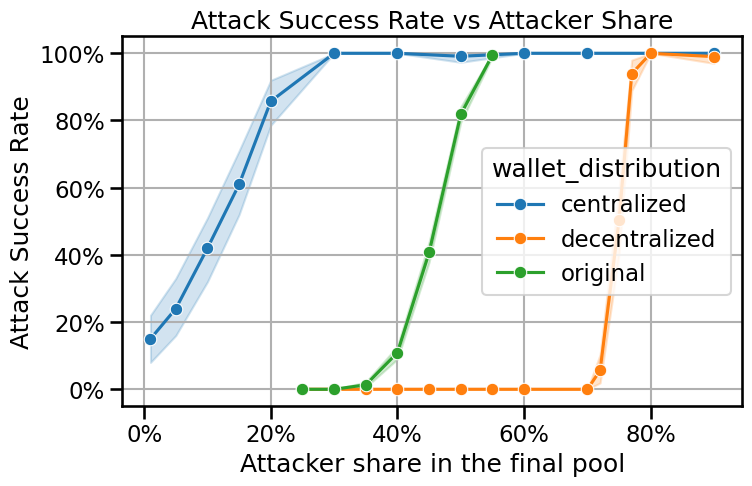

In [40]:
from experiments.analysis_utils.visualization import plot_attack_success_rate
fig = plot_attack_success_rate(combined_timestep_data_df, combined_start_data_df, final_share=True, hue='wallet_distribution')
fig.gca().set_xlabel('Attacker share in the final pool')


(-0.05, 3.5)

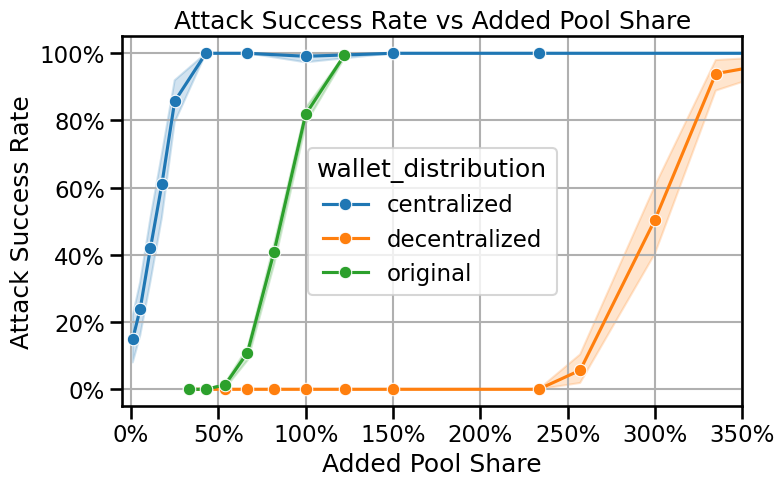

In [41]:
from experiments.analysis_utils.visualization import plot_attack_success_rate
fig = plot_attack_success_rate(combined_timestep_data_df, combined_start_data_df, final_share=False, hue='wallet_distribution')
fig.gca().set_xlim(-0.05, 3.5)


## Group dynamics

In [173]:
path_to_runs = Path("../../results/simulations/actors_labelling_centralized_and_decentralized")
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve(), pass_directory_name=False)

In [174]:
wallet_distribution_map = {
    'decentralized_wallet_distribution.csv': 'decentralized',
    'centralized_wallet_distribution.csv': 'centralized',
    'stETH token distribution  - stETH+wstETH holders.csv': 'original'
}
start_data_df_full['wallet_distribution'] = start_data_df_full['wallet_csv_name'].map(wallet_distribution_map)

In [178]:
proposal_df_full_original, start_data_df_full_original, timestep_data_df_full_original = read_directory(Path("../../results/simulations/actors_labelling_original"), pass_directory_name=False)
start_data_df_full_original['wallet_distribution'] = 'original'

max_run_id = start_data_df_full['run_id'].max()

proposal_df_full_original['run_id'] = proposal_df_full_original['run_id'] + max_run_id
start_data_df_full_original['run_id'] = start_data_df_full_original['run_id'] + max_run_id
timestep_data_df_full_original['run_id'] = timestep_data_df_full_original['run_id'] + max_run_id

timestep_data_df_full = pd.concat([timestep_data_df_full, timestep_data_df_full_original], ignore_index=True)
start_data_df_full = pd.concat([start_data_df_full, start_data_df_full_original], ignore_index=True)
proposal_df_full = pd.concat([proposal_df_full, proposal_df_full_original], ignore_index=True)

In [179]:
from experiments.analysis_utils.metrics import calculate_time_to_first_veto

veto_times = calculate_time_to_first_veto(timestep_data_df_full)
veto_times['veto_success'] = veto_times['time_to_first_veto'].notna()

timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full[['run_id', 'determining_factor', 'wallet_distribution']], on='run_id')
timestep_data_df_first_timestep = timestep_data_df_full_with_params.loc[timestep_data_df_full_with_params['timestep'] == 1].copy()
timestep_data_df_first_timestep['normal_share']  = timestep_data_df_first_timestep.balance_Normal / timestep_data_df_first_timestep.actors_total_balance
timestep_data_df_first_timestep['quick_share'] = timestep_data_df_first_timestep.balance_Quick / timestep_data_df_first_timestep.actors_total_balance
timestep_data_df_first_timestep['normal_defending_share'] = timestep_data_df_first_timestep.normal_share * timestep_data_df_first_timestep.determining_factor / 100
timestep_data_df_first_timestep['quick_defending_share'] = timestep_data_df_first_timestep.quick_share * timestep_data_df_first_timestep.determining_factor / 100
timestep_data_df_first_timestep['defending_share'] = timestep_data_df_first_timestep.normal_defending_share + timestep_data_df_first_timestep.quick_defending_share
timestep_data_df_first_timestep['defending_share_relative'] = timestep_data_df_first_timestep.defending_share / 0.01
timestep_data_df_first_timestep = timestep_data_df_first_timestep.merge(veto_times, on='run_id')

Optimization terminated successfully.
         Current function value: 0.134365
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:           veto_success   No. Observations:                16330
Model:                          Logit   Df Residuals:                    16328
Method:                           MLE   Df Model:                            1
Date:                Thu, 26 Dec 2024   Pseudo R-squ.:                  0.8048
Time:                        15:56:09   Log-Likelihood:                -2194.2
converged:                       True   LL-Null:                       -11241.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -31.6408      0.674    -46.954      0.000     -32.96

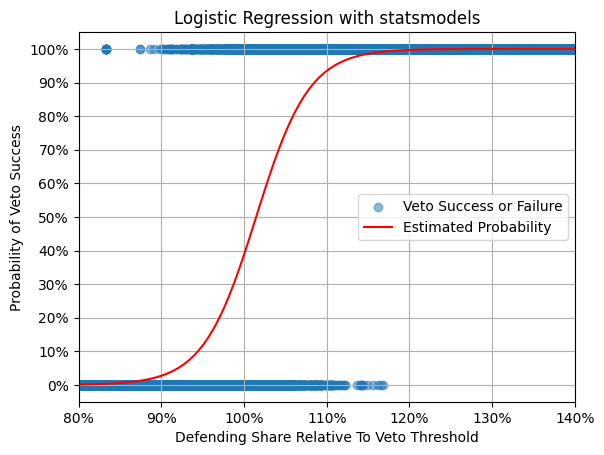

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.ticker import PercentFormatter

# Extract x and y
x_data = timestep_data_df_first_timestep['defending_share_relative']
y_data = timestep_data_df_first_timestep['veto_success']

# Prepare the data for statsmodels
X = sm.add_constant(x_data)  # Add a constant term for the intercept

# Fit the logistic regression model
model = sm.Logit(y_data, X)
result = model.fit()

# Print the summary of the model
print(result.summary())

# Predict probabilities
# x_fit = np.linspace(x_data.min(), x_data.max(), 100)
x_fit = np.linspace(0.8, 1.4, 100)
X_fit = sm.add_constant(x_fit)
y_prob = result.predict(X_fit)

# Plot the data and the logistic curve
plt.scatter(x_data, y_data, alpha=0.5, label='Veto Success or Failure')
plt.plot(x_fit, y_prob, color='red', label='Estimated Probability')
plt.xlabel('Defending Share Relative To Veto Threshold')
plt.ylabel('Probability of Veto Success')
plt.title('Logistic Regression with statsmodels')
plt.legend()
plt.xlim(0.8, 1.4)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.grid()

In [181]:
from experiments.analysis_utils.metrics import analyze_veto_timing_by_seals
timestep_data_df_full_with_params = timestep_data_df_full.merge(start_data_df_full, on='run_id')
veto_stats = analyze_veto_timing_by_seals(timestep_data_df_full, start_data_df_full, additional_columns=('wallet_distribution', 'determining_factor'))
veto_stats


veto_rate  \
first_seal_rage_quit_support second_seal_rage_quit_support wallet_distribution determining_factor               
0.01                         0.1                           centralized         0                     0.000000   
                                                                               10                    0.000000   
                                                                               20                    0.000000   
                                                                               30                    0.000000   
                                                                               40                    0.000000   
                                                                               50                    0.000000   
                                                                               60                    0.000000   
                                                                               70                    0.000000   
                                                                               72                    1.886792   
                                                                               75                    8.080808   
                                                                               77                   10.101010   
                                                                               80                   17.000000   
                                                                               90                   57.000000   
                                                                               100                  93.000000   
                                                           decentralized       0                     0.000000   
                                                                               10                    0.000000   
                                                                               20                    0.000000   
                                                                               22                    1.886792   
                                                                               25                   39.393939   
                                                                               27                   78.787879   
                                                                               30                   99.000000   
                                                                               40                  100.000000   
                                                                               50                  100.000000   
                                                                               60                  100.000000   
                                                                               70                  100.000000   
                                                                               80                  100.000000   
                                                                               90                  100.000000   
                                                           original            40                    0.754717   
                                                                               43                    1.320755   
                                                                               46                    5.454545   
                                                                               49                   14.545455   
                                                                               52                   31.616162   
                                                                               55                   53.939394   
                                                                               58                   74.066986   
                                

<Axes: xlabel='determining_factor', ylabel='veto_rate'>

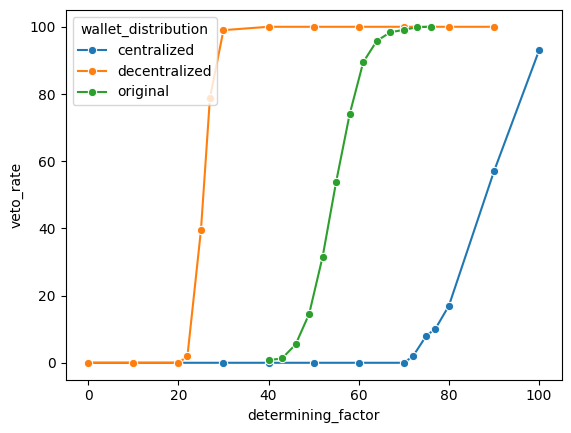

In [182]:
sns.lineplot(data=veto_stats, x='determining_factor', y='veto_rate', hue='wallet_distribution', marker='o')

# Cluster C

## Bribing

In [190]:
path_to_runs = Path("../../results/simulations/bribed_withdrawal_queue_replacement_futureproof/")
print(path_to_runs.resolve())
print(path_to_runs.resolve().exists())
proposal_df_full, start_data_df_full, timestep_data_df_full = read_directory(path_to_runs.resolve())
print(len(start_data_df_full))
start_data_df_full['wallet_distribution'] = start_data_df_full['wallet_csv_name'].map(wallet_distribution_map)

/home/rotsker/PycharmProjects/dg-research-revision/results/simulations/bribed_withdrawal_queue_replacement
True
1000


In [192]:
proposal_df_full_original, start_data_df_full_original, timestep_data_df_full_original = read_directory(Path("../../results/simulations/bribed_withdrawal_queue_replacement_normal"), pass_directory_name=False)
start_data_df_full_original['wallet_distribution'] = 'original'

max_run_id = start_data_df_full['run_id'].max()

proposal_df_full_original['run_id'] = proposal_df_full_original['run_id'] + max_run_id
start_data_df_full_original['run_id'] = start_data_df_full_original['run_id'] + max_run_id
timestep_data_df_full_original['run_id'] = timestep_data_df_full_original['run_id'] + max_run_id

timestep_data_df_full = pd.concat([timestep_data_df_full, timestep_data_df_full_original], ignore_index=True)
start_data_df_full = pd.concat([start_data_df_full, start_data_df_full_original], ignore_index=True)
proposal_df_full = pd.concat([proposal_df_full, proposal_df_full_original], ignore_index=True)

In [197]:
start_data_df_full['early_responders_count'] = start_data_df_full.quick_and_normal_early_responders_count
start_data_df_full['early_responders_tokens'] = start_data_df_full.quick_and_normal_early_responders_stETH_funds + start_data_df_full.quick_and_normal_early_responders_wstETH_funds
total_funds = timestep_data_df_full.groupby('run_id').actors_total_balance.first()
start_data_df_full['early_responders_tokens_relative'] = (
    start_data_df_full['early_responders_tokens'] / 
    start_data_df_full['run_id'].map(total_funds))
start_data_df_full['amount_needed_to_bribe'] = start_data_df_full['early_responders_tokens_relative'] - 0.01

agg_results = start_data_df_full.groupby('wallet_distribution').agg(
    {
        'early_responders_count': ('median'),
        'early_responders_tokens_relative': ('median'),
        'amount_needed_to_bribe': ('median')
    }
)
agg_results = agg_results.clip(lower=0)
print('Median values for bribing stats in different wallet distributions:')
agg_results.reindex(['centralized', 'original', 'decentralized'])

Median values for bribing stats in different wallet distributions:


,early_responders_count,early_responders_tokens_relative,amount_needed_to_bribe
wallet_distribution,,,
centralized,262.0,0.011414,0.001414
original,237.0,0.014362,0.004362
decentralized,237.0,0.039612,0.029612


We can see that bribing amount is much higher than in case of original token distribution. It is even higher than with fast reactions.

# Wallet analysis

In [239]:
from experiments.analysis_utils.wallets import add_total_token_share, count_n_wallets_threshold, get_token_array, count_distinct_first_wallets

def mode(a):
    u, c = np.unique(a, return_counts=True)
    return u[c.argmax()]

wallet_df_list = []
for p in Path('../../data').glob('*.csv'):
    wallet_df = pd.read_csv(p)
    wallet_df = add_total_token_share(wallet_df)
    wallet_df['wallet_distribution'] = wallet_distribution_map[p.name]
    wallet_df_list.append(wallet_df)
wallet_df_combined = pd.concat(wallet_df_list, ignore_index=True)

In [240]:
wallet_basic_stats = wallet_df_combined.groupby('wallet_distribution').agg(
    {
        'total_token_share': ('mean', 'median', mode)
    }
)
wallet_basic_stats *= 100
wallet_basic_stats.reindex(['centralized', 'original', 'decentralized'])


total_token_share                    
                                 mean    median      mode
wallet_distribution                                      
centralized                  5.035247  0.303036  0.025047
original                     5.035247  0.741906  0.116745
decentralized                5.035247  1.710941  1.129766

In [251]:
import pandas as pd
import numpy as np

wallet_types = ['Private', 'Other', 'No label']
thresholds = np.array([.5, .75, 1., 1.25, 1.5, 1.75, 2.])

# Define the group sizes you want to calculate
group_sizes = [1, 2, 3, 4]  # You can change this to [1, 2, 3, 5] or any other combination

# Prepare a list to hold the data for the DataFrame
data = []

for wallet_distribution, group_df in wallet_df_combined.groupby('wallet_distribution'):
    for threshold in thresholds:
        # Initialize a dictionary to hold the counts for each group size
        counts = {'wallet_distribution': wallet_distribution, 'threshold': threshold}
        
        # Calculate the counts for each group size
        for size in group_sizes:
            combinations, _ = count_n_wallets_threshold(group_df, wallet_types, threshold, size)
            distinct_first_wallets = count_distinct_first_wallets(group_df, wallet_types, threshold, size)
            # Use dynamic key names based on the size
            counts[f'group_of_{size}_combinations'] = combinations
            counts[f'group_of_{size}_distinct_first_wallets'] = distinct_first_wallets
        # Append the counts dictionary to the data list
        data.append(counts)

# Create a DataFrame from the data list
df = pd.DataFrame(data)

In [252]:
df

,wallet_distribution,threshold,group_of_1_combinations,group_of_1_distinct_first_wallets,group_of_2_combinations,group_of_2_distinct_first_wallets,group_of_3_combinations,group_of_3_distinct_first_wallets,group_of_4_combinations,group_of_4_distinct_first_wallets
0,centralized,0.50,4,4,7727,16,7509318,21,4817176754,25
1,centralized,0.75,2,2,3644,6,3323039,15,2022249427,18
2,centralized,1.00,1,1,1870,3,1751862,7,1097046338,14
3,centralized,1.25,1,1,1811,2,1640313,5,990964239,9
4,centralized,1.50,0,0,32,1,66654,3,69156133,5
5,centralized,1.75,0,0,7,1,13469,2,13069152,4
6,centralized,2.00,0,0,1,1,1970,1,1957638,2
7,decentralized,0.50,6,6,11627,18,11939230,29,8816776454,42
8,decentralized,0.75,2,2,3772,10,3648030,17,2425499933,25
9,decentralized,1.00,2,2,3620,5,3281280,13,1993000693,17


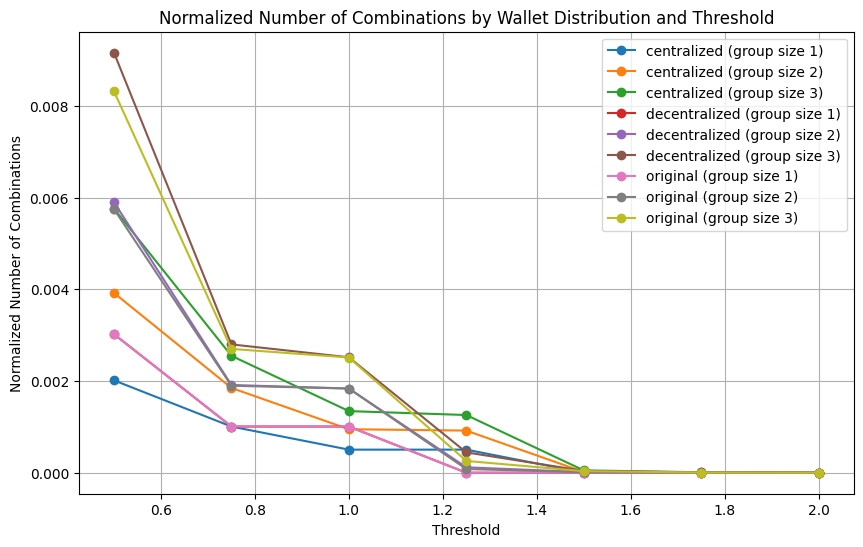

In [254]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import comb

# Example DataFrame structure
# df = pd.DataFrame({
#     'wallet_distribution': ['centralized', 'centralized', 'decentralized', ...],
#     'threshold': [0.5, 0.75, 0.5, ...],
#     'group_of_1_combinations': [10, 15, 8, ...],
#     'group_of_2_combinations': [5, 10, 4, ...],
#     ...
# })

# Define the group sizes you want to plot
group_sizes = [1, 2, 3]  # Example group sizes

# Calculate the maximum possible number of combinations for each wallet distribution and group size
max_possible_combinations = {}
for wallet_distribution in df['wallet_distribution'].unique():
    token_array_length = len(wallet_df_combined[wallet_df_combined['wallet_distribution'] == wallet_distribution])
    for size in group_sizes:
        max_possible_combinations[(wallet_distribution, size)] = comb(token_array_length, size)

# Normalize the number of combinations for each group size
for size in group_sizes:
    column_name = f'group_of_{size}_combinations'
    df[f'normalized_{column_name}'] = df.apply(
        lambda row: row[column_name] / max_possible_combinations[(row['wallet_distribution'], size)],
        axis=1
    )

# Plot the data
plt.figure(figsize=(10, 6))
for wallet_distribution in df['wallet_distribution'].unique():
    for size in group_sizes:
        column_name = f'normalized_group_of_{size}_combinations'
        subset = df[df['wallet_distribution'] == wallet_distribution]
        plt.plot(subset['threshold'], subset[column_name], marker='o', label=f'{wallet_distribution} (group size {size})')

plt.xlabel('Threshold')
plt.ylabel('Normalized Number of Combinations')
plt.title('Normalized Number of Combinations by Wallet Distribution and Threshold')
plt.legend()
plt.grid(True)
plt.show()

<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_14226/174474161.py:26: SyntaxWarning: invalid escape sequence '\d'
  melted_df['group_size'] = melted_df['group_size'].str.extract('(\d+)').astype(int)


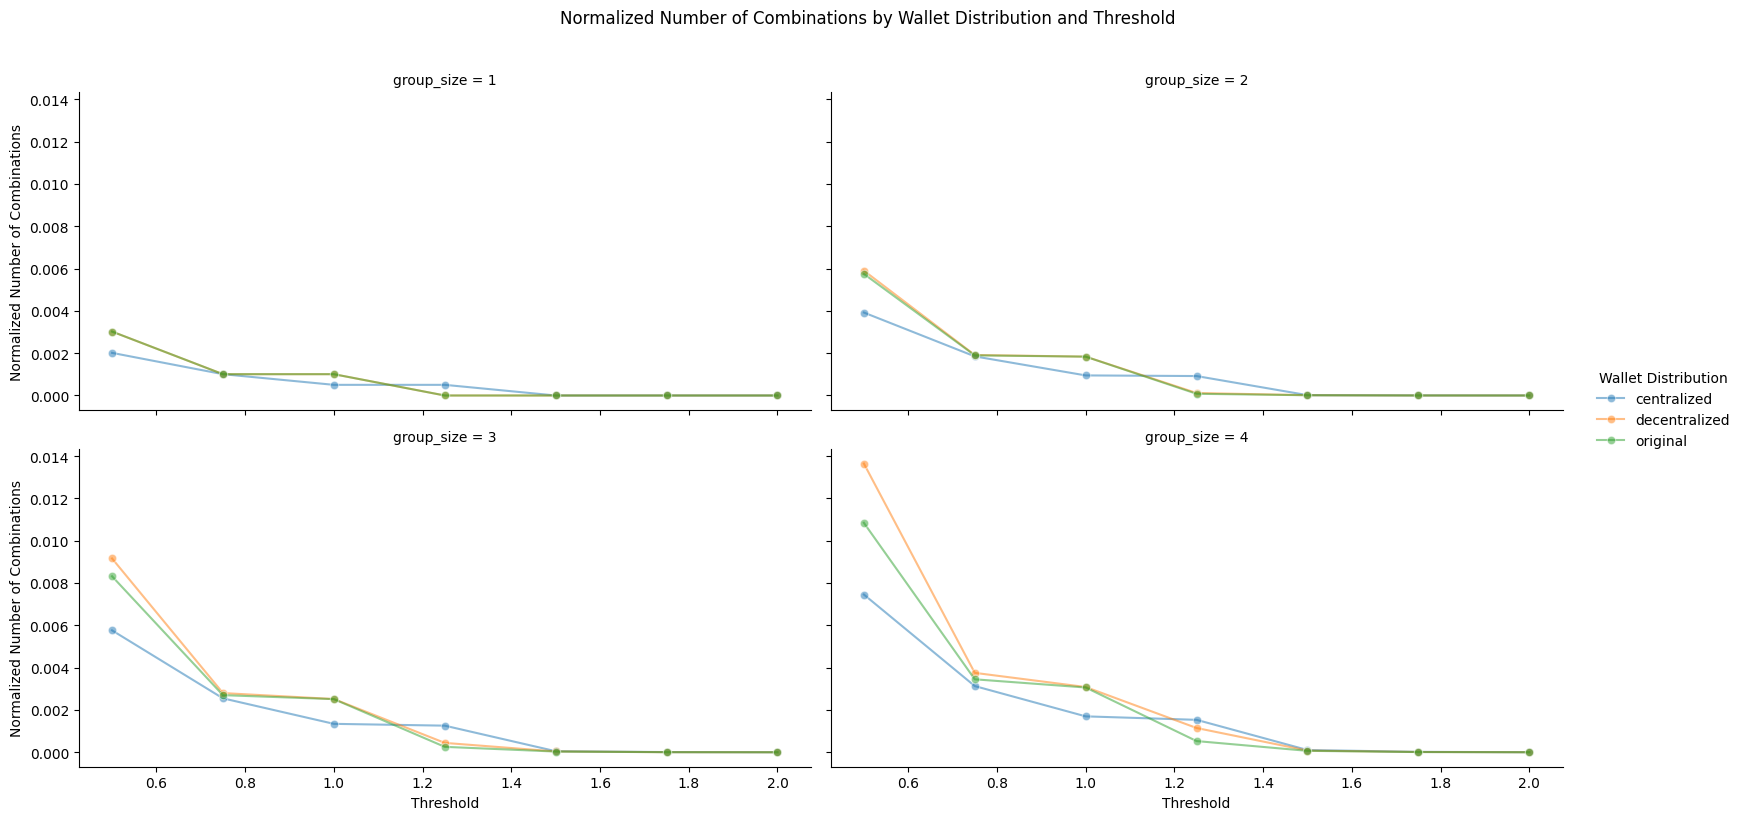

In [266]:
from scipy.special import comb

group_sizes = [1, 2, 3, 4]  # Example group sizes

# Calculate the maximum possible number of combinations for each wallet distribution and group size
max_possible_combinations = {}
for wallet_distribution in df['wallet_distribution'].unique():
    token_array_length = len(wallet_df_combined[wallet_df_combined['wallet_distribution'] == wallet_distribution])
    for size in group_sizes:
        max_possible_combinations[(wallet_distribution, size)] = comb(token_array_length, size)

# Normalize the number of combinations for each group size
for size in group_sizes:
    column_name = f'group_of_{size}_combinations'
    df[f'normalized_{column_name}'] = df.apply(
        lambda row: row[column_name] / max_possible_combinations[(row['wallet_distribution'], size)],
        axis=1
    )

# Melt the DataFrame for seaborn
melted_df = df.melt(id_vars=['wallet_distribution', 'threshold'], 
                    value_vars=[f'normalized_group_of_{size}_combinations' for size in group_sizes],
                    var_name='group_size', value_name='normalized_combinations')

# Extract group size from the column name
melted_df['group_size'] = melted_df['group_size'].str.extract('(\d+)').astype(int)

# Plot using seaborn FacetGrid
g = sns.FacetGrid(melted_df, col='group_size', col_wrap=2, hue='wallet_distribution', height=4, aspect=2, margin_titles=True, sharex=True, sharey=True)
g.map(sns.lineplot, 'threshold', 'normalized_combinations', marker='o', alpha=0.5).add_legend(title='Wallet Distribution')

g.set_axis_labels('Threshold', 'Normalized Number of Combinations')
g.set_titles(row_template='Group Size: {row_name}')
g.fig.suptitle('Normalized Number of Combinations by Wallet Distribution and Threshold', y=1.02)
# g.set(ylim=(0, 1))  # Assuming normalization results in values between 0 and 1
g.tight_layout()
plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_14226/3365722683.py:9: SyntaxWarning: invalid escape sequence '\d'
  melted_df['group_size'] = melted_df['group_size'].str.extract('(\d+)').astype(int)


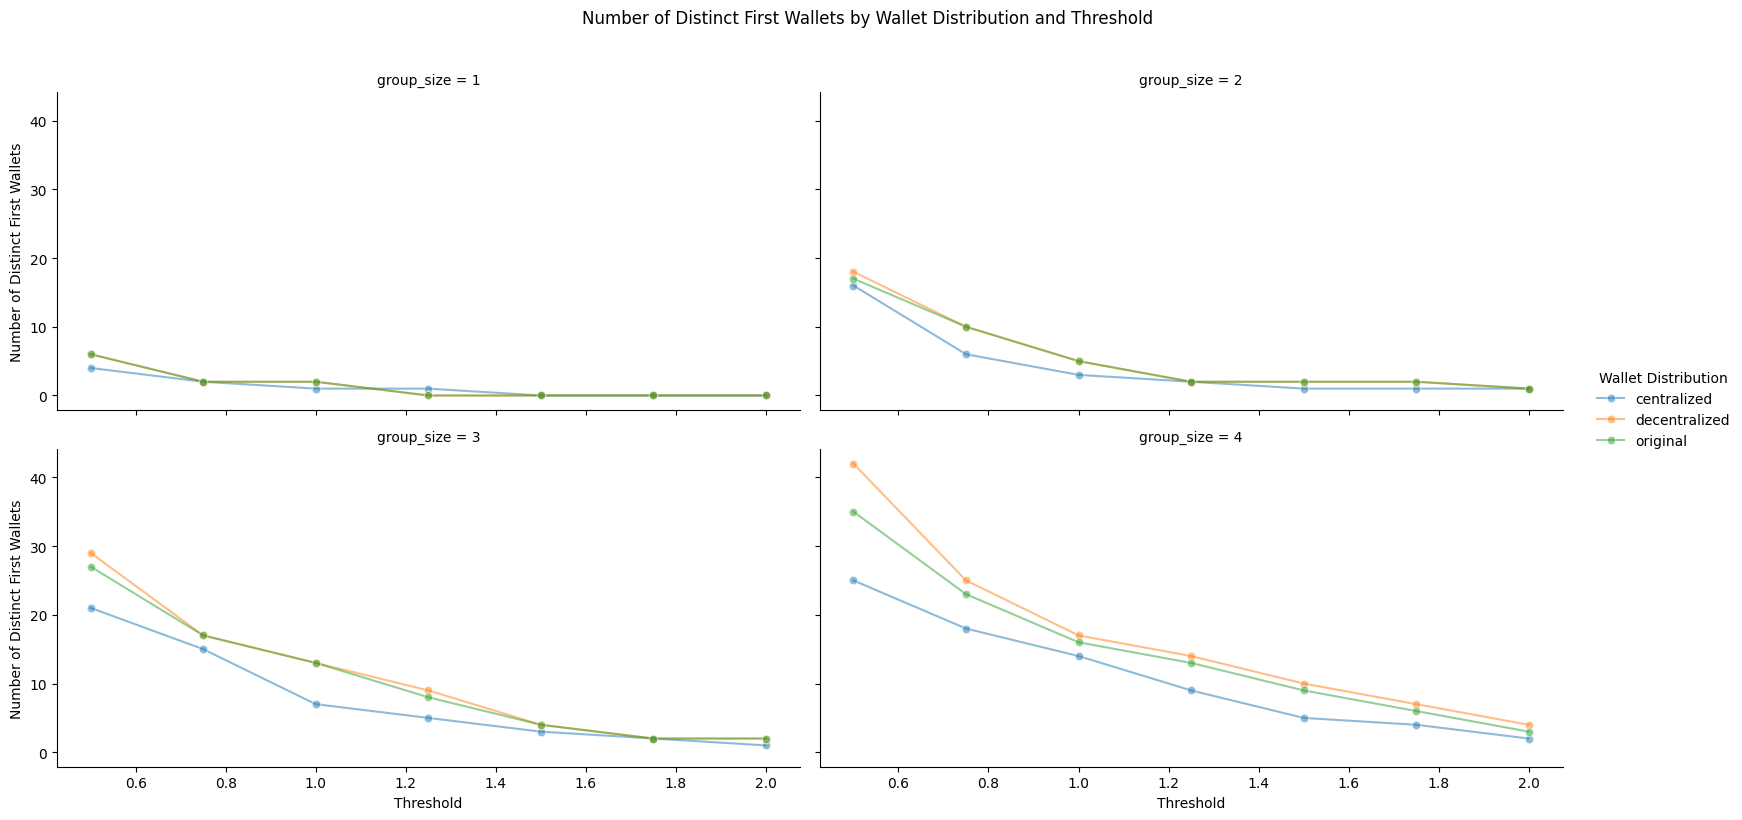

In [267]:
group_sizes = [1, 2, 3, 4]  # Example group sizes

# Melt the DataFrame for seaborn
melted_df = df.melt(id_vars=['wallet_distribution', 'threshold'], 
                    value_vars=[f'group_of_{size}_distinct_first_wallets' for size in group_sizes],
                    var_name='group_size', value_name='distinct_first_wallets')

# Extract group size from the column name
melted_df['group_size'] = melted_df['group_size'].str.extract('(\d+)').astype(int)

# Plot using seaborn FacetGrid
g = sns.FacetGrid(melted_df, col='group_size', col_wrap=2, hue='wallet_distribution', height=4, aspect=2, margin_titles=True)
g.map(sns.lineplot, 'threshold', 'distinct_first_wallets', marker='o', alpha=0.5).add_legend(title='Wallet Distribution')

g.set_axis_labels('Threshold', 'Number of Distinct First Wallets')
g.set_titles(row_template='Group Size: {row_name}')
g.fig.suptitle('Number of Distinct First Wallets by Wallet Distribution and Threshold', y=1.02)
g.tight_layout()
plt.show()